In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_perspective_rectangle(image_path):
    # Загрузка изображения
    img = cv2.imread(image_path)
    if img is None:
        print("Ошибка загрузки изображения")
        return
    
    # 1. Предварительная обработка
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.bilateralFilter(gray, 11, 17, 17)  # Сохраняем границы
    
    # 2. Детектирование границ с адаптивным порогом
    v = np.median(blurred)
    lower = int(max(0, (1.0 - 0.33) * v))
    upper = int(min(255, (1.0 + 0.33) * v))
    edges = cv2.Canny(blurred, lower, upper)
    
    # 3. Улучшение границ (закрытие разрывов)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # 4. Поиск линий с помощью HoughLinesP
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100,
        minLineLength=100, 
        maxLineGap=10
    )
    
    if lines is None:
        print("Линии не найдены")
        cv2.imshow("Result", img)
        cv2.waitKey(0)
        return
    
    # 5. Фильтрация и объединение линий
    horizontal = []
    vertical = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        
        # Фильтрация почти горизонтальных линий
        if abs(angle) < 30 or abs(180 - abs(angle)) < 30:
            horizontal.append(line[0])
        # Фильтрация почти вертикальных линий
        elif abs(90 - abs(angle)) < 30:
            vertical.append(line[0])
    
    # 6. Поиск пересечений для формирования прямоугольника
    intersections = []
    for h in horizontal:
        for v in vertical:
            # Вычисление точки пересечения
            x1, y1, x2, y2 = h
            x3, y3, x4, y4 = v
            
            # Параметрическое уравнение линий
            denom = (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
            if abs(denom) < 1e-5:  # Параллельные линии
                continue
                
            ua = ((x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)) / denom
            ub = ((x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)) / denom
            
            if 0 <= ua <= 1 and 0 <= ub <= 1:
                x = x1 + ua * (x2 - x1)
                y = y1 + ua * (y2 - y1)
                intersections.append((int(x), int(y)))
    
    # 7. Поиск выпуклой оболочки для точек пересечения
    if len(intersections) < 4:
        print("Недостаточно точек для формирования прямоугольника")
        cv2.imshow("Result", img)
        cv2.waitKey(0)
        return
    
    # Преобразование точек в формат для convexHull
    points = np.array(intersections)
    hull = cv2.convexHull(points)
    
    # Аппроксимация контура до 4 точек
    epsilon = 0.02 * cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)
    
    # 8. Фильтрация по количеству углов
    if len(approx) != 4:
        print("Не удалось найти четырехугольник")
        cv2.imshow("Result", img)
        cv2.waitKey(0)
        return
    
    # 9. Отображение результата
    result = img.copy()
    cv2.polylines(result, [approx], True, (0, 255, 0), 3)
    
    # Вывод координат вершин
    print("Вершины прямоугольника:")
    for i, point in enumerate(approx):
        x, y = point[0]
        print(f"Угол {i+1}: ({x}, {y})")
        cv2.circle(result, (x, y), 8, (0, 0, 255), -1)
        cv2.putText(result, str(i+1), (x+10, y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Показ результата
    cv2.imshow("Detected Rectangle", result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Пример использования
import os
path = "./data"
for root, dirs, files in os.walk(path):
    for file in files:
        full_path = os.path.join(root, file)
        detect_perspective_rectangle(full_path)


Не удалось найти четырехугольник


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/sweepy/.local/share/pyenv/versions/3.11.0/lib/python3.11/site-packages/cv2/qt/plugins"


Вершины прямоугольника:
Угол 1: (826, 474)
Угол 2: (279, 401)
Угол 3: (403, 228)
Угол 4: (826, 370)
Не удалось найти четырехугольник
Не удалось найти четырехугольник


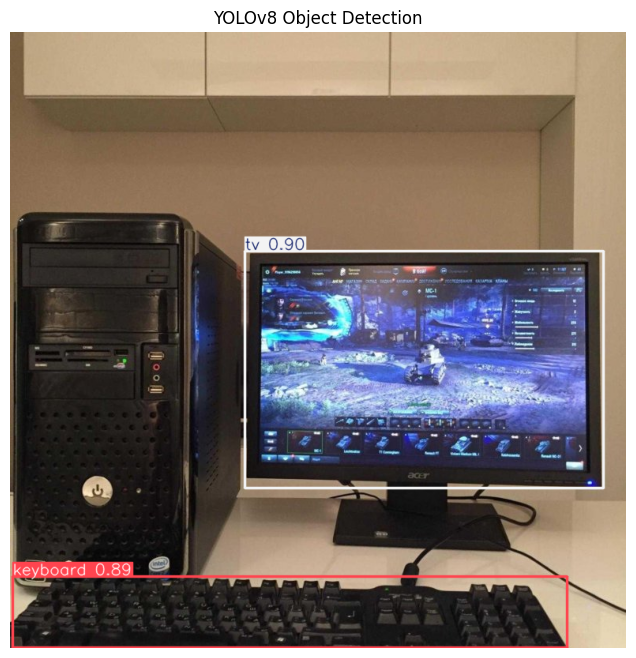

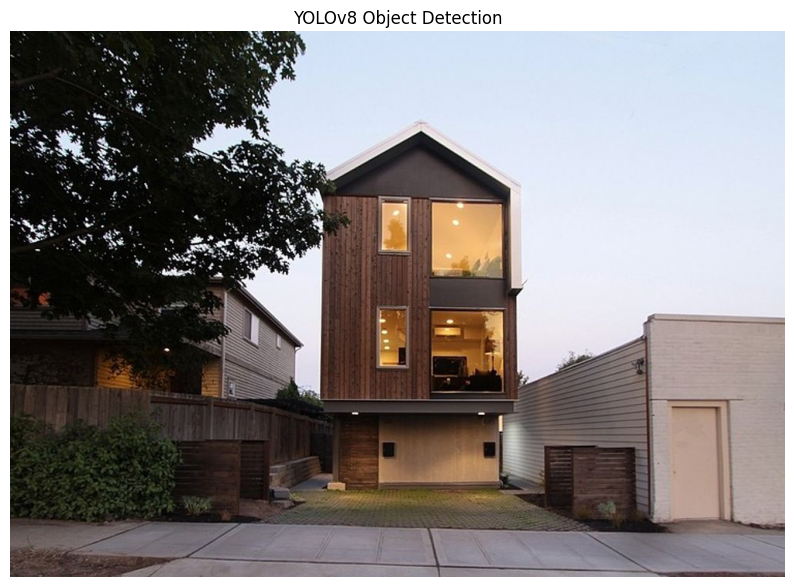

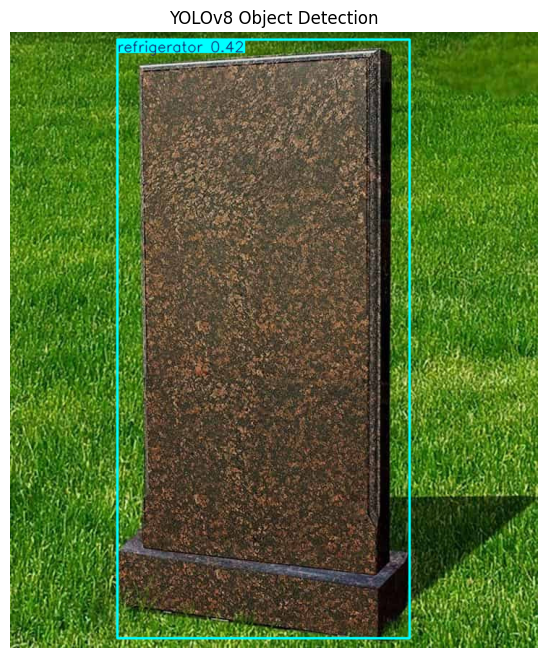

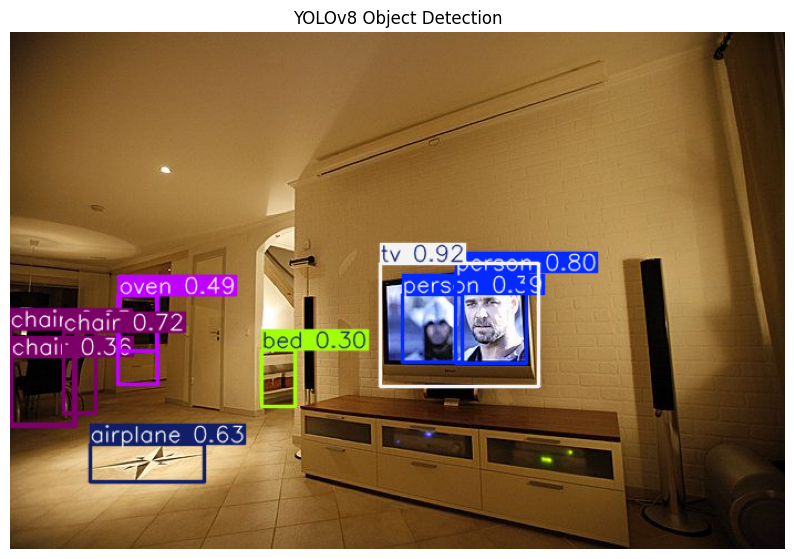

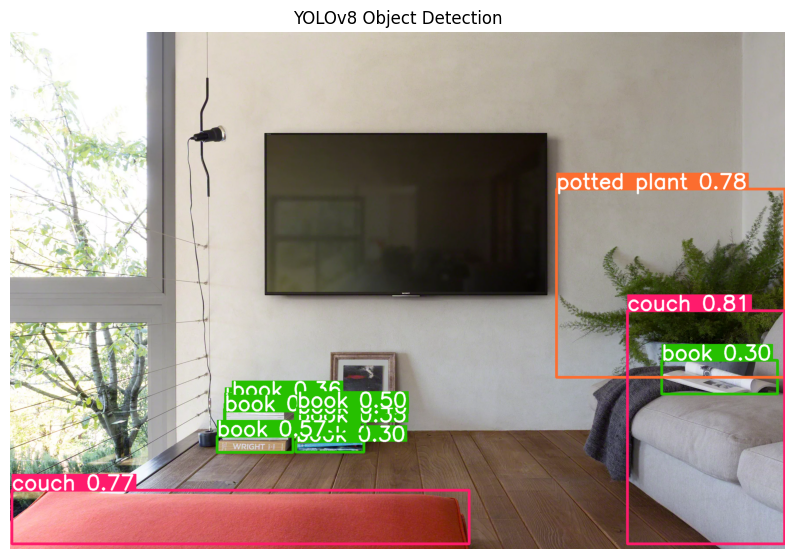

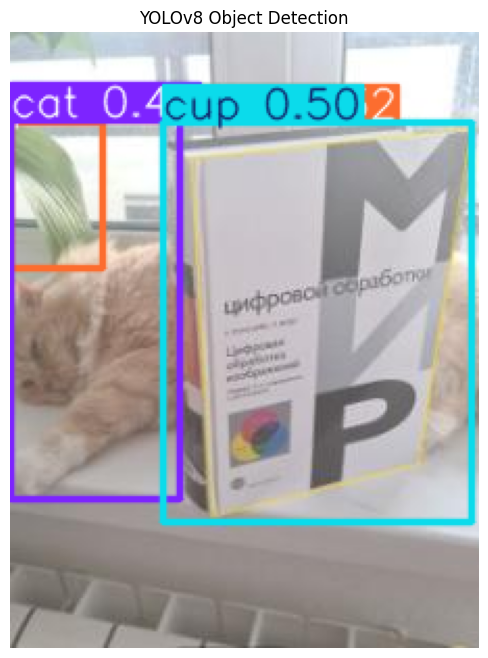

In [18]:


from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def detect_objects_yolov8(image_path):
    # Загружаем предобученную модель YOLOv8 (средняя версия)
    model = YOLO('yolov8m.pt')  # весы будут скачаны автоматически при первом запуске

    # Выполняем предсказание (детекцию) на изображении
    results = model.predict(source=image_path, conf=0.3, verbose=False)

    # Результат — список объектов с координатами и классами
    for r in results:
        # Получаем изображение с нанесёнными рамками (BGR)
        img_bgr = r.plot()
        # Конвертируем в RGB для matplotlib
        img_rgb = img_bgr[..., ::-1]

        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title('YOLOv8 Object Detection')
        plt.show()

        # Выводим информацию о найденных объектах



import os
path = "./data"
for root, dirs, files in os.walk(path):
    for file in files:
        full_path = os.path.join(root, file)
        detect_objects_yolov8(full_path)
